In [1]:
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageDraw, ImageFont
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

from skimage import feature
from skimage.feature import graycomatrix, graycoprops
# from skimage.feature import greycomatrix, greycoprops
from glob import glob # Used to easily find file paths
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, auc


# LBP + GLCM

### First step is to loud the data

In [2]:
# Loud the data folder and the images
col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
df = pd.read_csv('data2.txt', sep="\s+", names=col_names, header=None)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)

images_path = "all-mias"

all_images = []
all_labels = []
all_groups = []

for filename in sorted(os.listdir(images_path)):
    if filename.lower().endswith('.pgm'):
        ref_num = os.path.splitext(filename)[0]
        record = df[df['REFNUM'] == ref_num]

        if not record.empty:
            full_path = os.path.join(images_path, filename)
            img_array = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img_eq = clahe.apply(img_array)

            labels = record['CANCER'].iloc[0]
            x, y, radius = record[['X', 'Y', 'RADIUS']].iloc[0]
            
            # Handle ROI extraction
            if labels == 1 and pd.notna(x) and pd.notna(y) and pd.notna(radius):
                # Adjust for bottom-left origin: flip Y coordinate
                x, y, radius = int(x), int(1024 - float(y)), int(radius)  # Y = 1024 - y for top-left origin
                # Crop a square ROI around (x, y) with size 2*radius
                roi = img_eq[max(0, y-radius):min(1024, y+radius), max(0, x-radius):min(1024, x+radius)]
                # Ensure ROI is not empty; resize to a fixed size (e.g., 128x128) for consistency
                if roi.size > 0:
                    roi = cv2.resize(roi, (256, 256), interpolation=cv2.INTER_AREA)
                else:
                    roi = img_eq  # Fallback to full image if ROI is invalid
            else:
                # For normal images or missing coordinates using all the image in full size
                roi = cv2.resize(img_eq, (256, 256), interpolation=cv2.INTER_AREA)
            
            all_images.append(roi)
            all_labels.append(labels)
            all_groups.append(ref_num[:-1])

print("Data has been louded successfully")
# plt.imshow(img_eq, cmap='gray')
## Print out the table from dataset
print(f"Image list {len(all_images)}")
print(f"Labels list {len(all_labels)}")
df.head(5)
# full details of the table

Data has been louded successfully
Image list 324
Labels list 324


,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,CANCER
0,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,0
1,mdb001,G,CIRC,B,535,425,197,1
2,mdb002,G,CIRC,B,522,280,69,1
3,mdb003,D,NORM,NaN,NaN,NaN,NaN,0
4,mdb004,D,NORM,NaN,NaN,NaN,NaN,0


In [3]:
# import os
# import cv2
# import numpy as np
# import pandas as pd

# # ---------- CONFIG ----------
# images_path = "all-mias"      # folder with .pgm files
# meta_path = "data2.txt"       # metadata (if df not already loaded)
# image_size = 1024             # original MIAS image size
# target_size = None            # e.g., 256 or None to keep native crop size
# min_side = 32                 # minimum side; pads if ROI smaller
# clahe_clip = 2.0
# clahe_tile = (8, 8)

# # ---------- read metadata (if not already) ----------
# col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
# df = pd.read_csv(meta_path, sep=r"\s+", names=col_names, header=None)
# df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)

# # compute median radius (useful for normal crops)
# radii = pd.to_numeric(df['RADIUS'], errors='coerce').dropna()
# median_radius = int(radii.median()) if radii.size > 0 else 48
# print("median_radius =", median_radius)

# # ---------- helper functions ----------
# def clamp(a, lo, hi):
#     return max(lo, min(hi, a))

# def crop_square(img, cx, cy, r):
#     """Crop a square [cy-r:cy+r, cx-r:cx+r] clamped to image boundaries."""
#     H, W = img.shape
#     x0 = clamp(cx - r, 0, W)
#     x1 = clamp(cx + r, 0, W)
#     y0 = clamp(cy - r, 0, H)
#     y1 = clamp(cy + r, 0, H)
#     # ensure at least 1-pixel slice
#     if x1 <= x0 or y1 <= y0:
#         return img.copy()
#     return img[y0:y1, x0:x1]

# def pad_to_min_side(img, min_side):
#     h, w = img.shape
#     top = bottom = left = right = 0
#     if h < min_side:
#         extra = min_side - h
#         top = extra // 2
#         bottom = extra - top
#     if w < min_side:
#         extra = min_side - w
#         left = extra // 2
#         right = extra - left
#     if any([top, bottom, left, right]):
#         # reflection padding avoids border artifacts
#         img = cv2.copyMakeBorder(img, top, bottom, left, right, borderType=cv2.BORDER_REFLECT)
#     return img

# def apply_clahe_to_roi(roi, clip=2.0, tile=(8,8)):
#     # Ensure uint8
#     if roi.dtype != np.uint8:
#         # if floats 0..1 or ints >255, scale appropriatelly
#         if roi.max() <= 1.0:
#             roi_u8 = (roi * 255).astype(np.uint8)
#         else:
#             roi_u8 = roi.astype(np.uint8)
#     else:
#         roi_u8 = roi
#     clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
#     return clahe.apply(roi_u8)

# def resize_roi(roi, target_size):
#     if target_size is None:
#         return roi
#     h, w = roi.shape
#     if h == target_size and w == target_size:
#         return roi
#     # prefer AREA for downsampling, LINEAR for upsampling
#     if h > target_size or w > target_size:
#         interp = cv2.INTER_AREA
#     else:
#         interp = cv2.INTER_LINEAR
#     return cv2.resize(roi, (target_size, target_size), interpolation=interp)

# # ---------- main ROI extraction ----------
# rois = []
# labels = []
# refs = []

# for filename in sorted(os.listdir(images_path)):
#     if not filename.lower().endswith('.pgm'):
#         continue
#     refnum = os.path.splitext(filename)[0]
#     row = df[df['REFNUM'] == refnum]
#     if row.empty:
#         # skip images without metadata (optional)
#         continue
#     row = row.iloc[0]
#     img_path = os.path.join(images_path, filename)
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     if img is None:
#         print("WARN: can't read", img_path)
#         continue

#     label = int(row['CANCER'])
#     x, y, r = row['X'], row['Y'], row['RADIUS']

#     # If abnormal and coordinates exist -> lesion-centered crop
#     if label == 1 and pd.notna(x) and pd.notna(y) and pd.notna(r):
#         cx = int(float(x))
#         # convert MIAS bottom-left Y to top-left indexing
#         cy = int(image_size - float(y))
#         rr = int(float(r))
#         # create crop (side = 2 * rr). If rr is tiny, enforce min_side
#         side = max(rr, min_side // 2)
#         roi = crop_square(img, cx, cy, side)
#     else:
#         # Normal or missing coords -> center crop with median radius
#         cx = img.shape[1] // 2
#         cy = img.shape[0] // 2
#         rr = median_radius
#         roi = crop_square(img, cx, cy, rr)

#     # pad if too small
#     roi = pad_to_min_side(roi, min_side)

#     # apply CLAHE per-ROI (uint8)
#     roi_clahe = apply_clahe_to_roi(roi, clip=clahe_clip, tile=clahe_tile)

#     # Optionally resize to fixed target size (set target_size at top)
#     roi_final = resize_roi(roi_clahe, target_size)

#     rois.append(roi_final)
#     labels.append(label)
#     refs.append(refnum)

# print("Extracted ROIs:", len(rois))
# # quick diagnostics
# shapes = [r.shape for r in rois]
# unique_shapes = {}
# for s in shapes:
#     unique_shapes[s] = unique_shapes.get(s, 0) + 1
# print("ROI shape counts:", unique_shapes)

# # Save a few sample before/after for QC (optional)
# import matplotlib.pyplot as plt
# n_show = min(4, len(rois))
# fig, axes = plt.subplots(2, n_show, figsize=(4*n_show, 6))
# for i in range(n_show):
#     # show original crop before CLAHE is not stored; we can re-create for debug if needed
#     axes[0, i].imshow(rois[i], cmap='gray')  # this is after CLAHE/resizing
#     axes[0, i].set_title(f"{refs[i]} L={labels[i]}")
#     axes[0, i].axis('off')
#     axes[1, i].imshow(rois[i], cmap='gray')
#     axes[1, i].set_title("After CLAHE")
#     axes[1, i].axis('off')
# plt.suptitle("Sample ROIs (after CLAHE and resize if applied)")
# plt.tight_layout()
# plt.show()
# all_images = rois            # list of ROI numpy arrays (after CLAHE / padding / optional resize)
# all_labels = labels          # list of 0/1 labels
# all_groups = refs

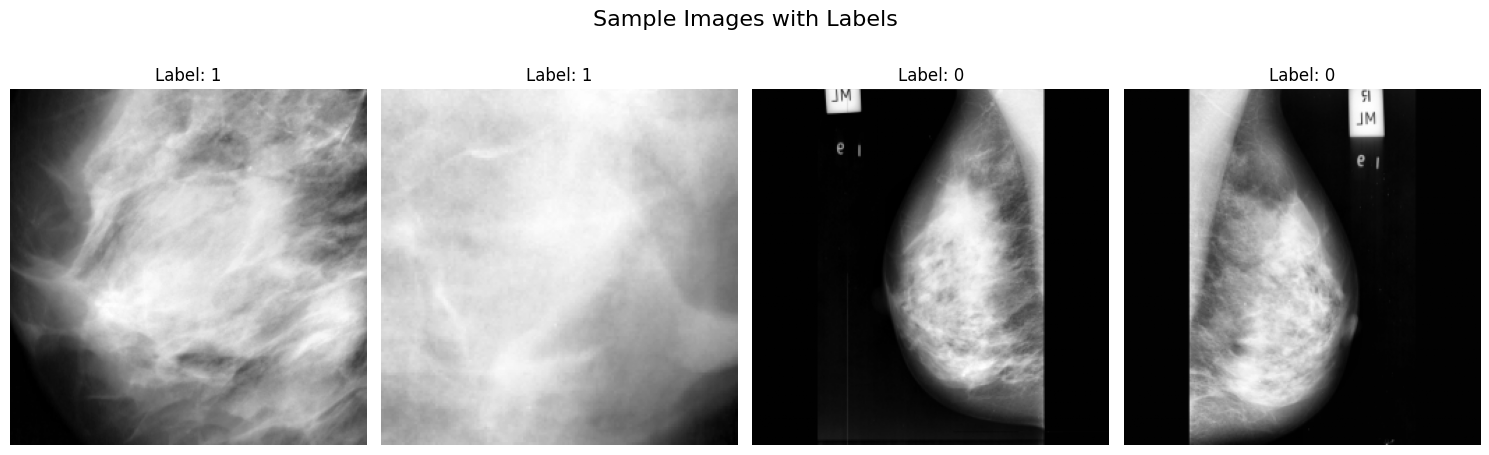

In [4]:
plt.figure(figsize=(15,5))

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(all_images[i], cmap='gray')
    plt.title(f"Label: {all_labels[i]}")
    plt.axis('off')
plt.suptitle("Sample Images with Labels", fontsize=16)
plt.tight_layout()
plt.show()

# GLCM

#### 2 - applyed the Gray-Level Co-occurrence Matrix (GLCM)


In [5]:
def extract_glcm_features(patch, 
                          distances=[1, 3, 5], 
                          angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], 
                          levels=256):
    """
    Compute GLCM and summary stats for a single gray‑scale patch (2D ndarray).
    Returns a dict: e.g. {'contrast_mean':…, 'contrast_var':…, 'homogeneity_mean':…, …}
    """
    patch = (patch * (levels - 1)).astype(np.uint8) if patch.max() <= 1 else patch.astype(np.uint8)
    
    glcm = graycomatrix(patch,
                        distances=distances,
                        angles=angles,
                        levels=levels,
                        symmetric=True,
                        normed=True)

    props = ['contrast', 'dissimilarity', 'homogeneity', 
             'ASM', 'energy', 'correlation']
    feats = {}
    for prop in props:
        mat = graycoprops(glcm, prop)  # shape = (len(distances), len(angles))
        feats[f'{prop}_mean'] = mat.mean()
        feats[f'{prop}_var']  = mat.var()
    return feats

In [6]:
# Pick an ROI or image
sample_img = all_images[0]  # or load one manually

# Call the GLCM function
features = extract_glcm_features(sample_img)

# Print the dictionary
print("GLCM Features:")
for key, value in features.items():
    print(f"{key}: {value:.4f}")


GLCM Features:
contrast_mean: 117.3914
contrast_var: 7297.5112
dissimilarity_mean: 7.2706
dissimilarity_var: 9.4094
homogeneity_mean: 0.1844
homogeneity_var: 0.0050
ASM_mean: 0.0003
ASM_var: 0.0000
energy_mean: 0.0181
energy_var: 0.0000
correlation_mean: 0.9854
correlation_var: 0.0001


# LBP
#### 3 - Applying the Local Binary Pattern (LPB)

c:\python3\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


324
Computing the image and histogram for pooling and classification...


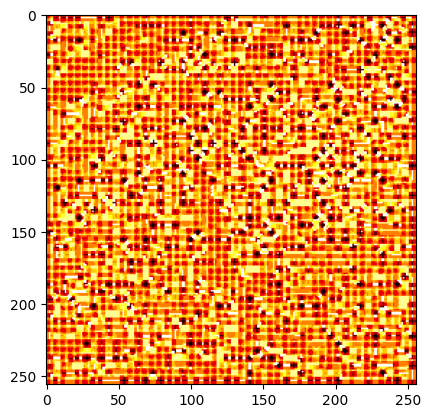

In [7]:
normalaized_img = [] # holding the LBP maps
    
for img in all_images:
    # Normalazing the image 
    if img.max() > img.min():
        n_img = ((img - img.min()) / (img.max() - img.min()) * 255) 
    else:
        n_img = img
    P = 8
    R = 3
    method = 'uniform'
    LBP = feature.local_binary_pattern(n_img, P, R, method)
    plt.imshow(LBP, cmap='hot')
    normalaized_img.append(LBP)
print(len(normalaized_img))
print("Computing the image and histogram for pooling and classification...")

def compute_histograms_for_each_region(normalaized_img, G=6, n_bins=59):
    #compute the histogram from 255 in image size to 59 =>  reduce the number of bins
    histogram = []
    """
    # Pooling the image in to 6 x 6
    H = 1020 # height
    W = 1020 # width
    #G = 6 # Number of Grid 6 * 6 
    hor = int(H / G) # height of each region
    wor = int(W / G) # width of each region
    """
    H, W = normalaized_img.shape
    hor, wor = H // G, W // G
# Pooling the data into 6 * 6 regions   
    for i in range(G):
        for j in range(G):
            row_start = i * hor
            row_end = (i + 1) * hor
            col_start = j * wor
            col_end = (i + 1) * wor
            region = normalaized_img[row_start:row_end, col_start:col_end]

            hist, _ = np.histogram(region.ravel(), bins=n_bins, range=(0, n_bins))
            hist = hist.astype(float)
            if hist.sum() > 0:    
                hist /= hist.sum()
        
            histogram.append(hist)

    return histogram

# print(normalaized_img)
# histogram = compute_histograms_for_each_region(normalaized_img)
# print(len(histogram))

Computed LBP maps and pooled matrices for 324 images


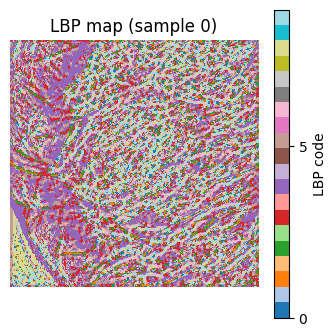

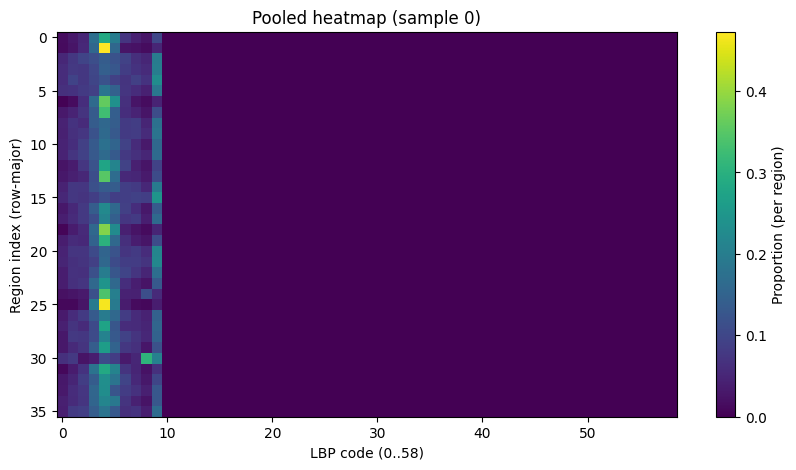

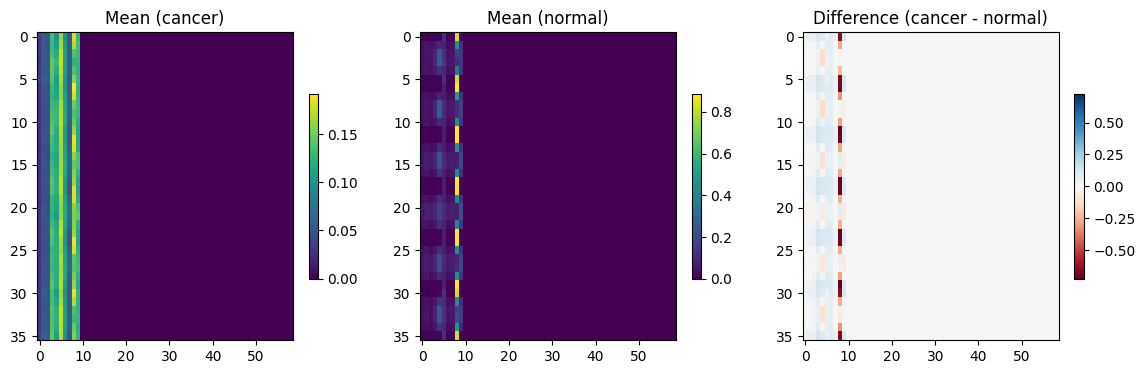

Top codes (more frequent in cancer overall): [ 3  6  5  2  9  7  1  0  4 10]
Top codes (more frequent in normal overall): [ 8 12 13 15 10 11 14 24 23 22]
Top codes (more frequent in cancer, center region): [ 8  5  6  3 12 11 10 14 15 13]
Top codes (more frequent in normal, center region): [ 4  9  0  1  2  7 10 11 14 13]


In [8]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

# Parameters (match your pipeline)
P = 8
R = 3
method = 'uniform'
n_bins = 59        # uniform LBP bins for P=8
G = 6              # pooling grid (6x6)
LBP_cmap = 'tab20' # discrete colormap for LBP map
heatmap_cmap = 'viridis'

# ---- Helper functions ----

def compute_lbp_map(img, P=8, R=3, method='uniform'):
    """
    img: 2D array (ROI). Accepts any numeric range; we cast to float for skimage,
         then convert the result to integer codes.
    Returns: lbp_map (int array) with values in [0, n_bins-1] (for uniform P=8 -> up to 58)
    """
    # ensure float input for local_binary_pattern
    lbp = local_binary_pattern(img.astype('float32'), P, R, method=method)
    # round/cast to int codes (uniform returns integers but as floats)
    lbp_codes = lbp.astype(int)
    return lbp_codes


def partition_edges(length, G):
    """
    Robust partition indices when length % G != 0.
    Returns array of edges of length G+1 (integers).
    """
    return np.linspace(0, length, G + 1, dtype=int)


def pooled_lbp_matrix(lbp_map, G=6, n_bins=59):
    """
    lbp_map: 2D int array of LBP codes (0..n_bins-1)
    Returns: M shape (G*G, n_bins) where each row is the L1-normalized histogram for a region.
    """
    H, W = lbp_map.shape
    row_edges = partition_edges(H, G)
    col_edges = partition_edges(W, G)
    rows = []
    for i in range(G):
        for j in range(G):
            r0, r1 = row_edges[i], row_edges[i+1]
            c0, c1 = col_edges[j], col_edges[j+1]
            region = lbp_map[r0:r1, c0:c1]
            # integer bins: 0..n_bins-1 -> use np.bincount
            hist = np.bincount(region.ravel(), minlength=n_bins).astype(float)
            total = hist.sum()
            if total > 0:
                hist /= total   # L1-normalize per region
            rows.append(hist)
    M = np.vstack(rows)  # shape (G*G, n_bins)
    return M


def plot_lbp_map(lbp_map, title="LBP map (codes)"):
    plt.figure(figsize=(4,4))
    plt.imshow(lbp_map, cmap=LBP_cmap, interpolation='nearest')
    cbar = plt.colorbar(ticks=np.arange(0, n_bins, 5))
    cbar.set_label('LBP code')
    plt.title(title)
    plt.axis('off')
    plt.show()


def plot_pooled_heatmap(M, title="Pooled LBP heatmap (regions × codes)"):
    """
    M: (G*G, n_bins)
    """
    plt.figure(figsize=(10,5))
    plt.imshow(M, aspect='auto', cmap=heatmap_cmap)
    plt.xlabel('LBP code (0..{})'.format(n_bins-1))
    plt.ylabel('Region index (row-major)')
    plt.title(title)
    plt.colorbar(label='Proportion (per region)')
    plt.show()


def class_mean_and_diff(ms_list, labels, pos_label=1):
    """
    ms_list: list of M matrices (one per ROI)
    labels: list/array of labels (same order)
    pos_label: label value considered 'positive' (cancer)
    Returns mean_pos, mean_neg, diff (pos - neg)
    """
    pos_Ms = [M for M,lab in zip(ms_list, labels) if lab == pos_label]
    neg_Ms = [M for M,lab in zip(ms_list, labels) if lab != pos_label]
    mean_pos = np.mean(np.stack(pos_Ms), axis=0) if len(pos_Ms) > 0 else np.zeros_like(ms_list[0])
    mean_neg = np.mean(np.stack(neg_Ms), axis=0) if len(neg_Ms) > 0 else np.zeros_like(ms_list[0])
    diff = mean_pos - mean_neg
    return mean_pos, mean_neg, diff


def top_discriminative_codes(diff, top_k=10, center_region_idx=None, G=6):
    """
    diff: mean_pos - mean_neg  (G*G, n_bins)
    If center_region_idx is provided, looks at that region's row to get top codes.
    Otherwise sums absolute differences across all regions to rank codes.
    """
    if center_region_idx is not None:
        arr = diff[center_region_idx]
        # codes increased in pos -> positive values
        idx_pos = np.argsort(-arr)[:top_k]
        idx_neg = np.argsort(arr)[:top_k]
        return idx_pos, idx_neg, arr
    else:
        # aggregate across regions
        agg = diff.sum(axis=0)
        idx_pos = np.argsort(-agg)[:top_k]
        idx_neg = np.argsort(agg)[:top_k]
        return idx_pos, idx_neg, agg


# ---- Example full workflow ----
# Assumes you already have: all_images (list of ROIs), all_labels (list)
# Step 1: compute LBP maps and pooled matrices for all ROIs

lbp_maps = []
pooled_Ms = []
for img in all_images:
    # normalize image to 0..255 if necessary (you already did this in your pipeline)
    if img.max() > img.min():
        n_img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
    else:
        n_img = img.astype(np.uint8)

    lbp = compute_lbp_map(n_img, P=P, R=R, method=method)
    M = pooled_lbp_matrix(lbp, G=G, n_bins=n_bins)

    lbp_maps.append(lbp)
    pooled_Ms.append(M)

print("Computed LBP maps and pooled matrices for", len(lbp_maps), "images")

# ---- Visualize one example (choose index) ----
idx = 0   # change to any sample index you want to inspect
plot_lbp_map(lbp_maps[idx], title=f'LBP map (sample {idx})')
plot_pooled_heatmap(pooled_Ms[idx], title=f'Pooled heatmap (sample {idx})')

# ---- Compute class means and difference ----
mean_pos, mean_neg, diff = class_mean_and_diff(pooled_Ms, all_labels, pos_label=1)

plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.imshow(mean_pos, aspect='auto', cmap=heatmap_cmap); plt.title('Mean (cancer)')
plt.colorbar(shrink=0.6)
plt.subplot(1,3,2); plt.imshow(mean_neg, aspect='auto', cmap=heatmap_cmap); plt.title('Mean (normal)')
plt.colorbar(shrink=0.6)
plt.subplot(1,3,3); plt.imshow(diff, aspect='auto', cmap='RdBu', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff))); plt.title('Difference (cancer - normal)')
plt.colorbar(shrink=0.6)
plt.show()

# ---- Print top discriminative codes (overall) ----
idx_pos, idx_neg, agg = top_discriminative_codes(diff, top_k=10, center_region_idx=None, G=G)
print("Top codes (more frequent in cancer overall):", idx_pos)
print("Top codes (more frequent in normal overall):", idx_neg)

# ---- If you want top codes in the central region specifically ----
center_row = G // 2
center_col = G // 2
center_region_idx = center_row * G + center_col
idx_pos_center, idx_neg_center, arr_center = top_discriminative_codes(diff, top_k=10, center_region_idx=center_region_idx, G=G)
print("Top codes (more frequent in cancer, center region):", idx_pos_center)
print("Top codes (more frequent in normal, center region):", idx_neg_center)


In [9]:
# Loop over your ROIs, build a DataFrame of features + labels + group IDs base on GLCM function
records = [] # records the data
for roi, label, grp in zip(all_images, all_labels, all_groups):
    glcm_feats = extract_glcm_features(roi)
    # lbp_feats  = compute_histograms_for_each_region(roi) # ?????????????
    glcm_feats['label'] = label
    glcm_feats['group'] = grp       
    records.append(glcm_feats)

    
df = pd.DataFrame.from_records(records) # sort the recorded data into the dataframe
print("GLCM feature matrix:", df.shape)
print(df.head())

# 3) Prepare for data training 
X = df.drop(columns=['label','group']).values
y = df['label'].values  

X_glcm = X

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##############################
##############################

x_list = []
y_list = []
for lbp_img, label in zip(normalaized_img, all_labels): # ??//??????????????
    histogram = compute_histograms_for_each_region(lbp_img)

    f_vector = np.concatenate(histogram)
    f_vector /= np.linalg.norm(f_vector) + 1e-10

    x_list.append(f_vector)
    y_list.append(label)

X = np.array(x_list)
y = np.array(y_list)
X_lbp = X
print("Function has been done successfully")

GLCM feature matrix: (324, 14)
   contrast_mean   contrast_var  dissimilarity_mean  dissimilarity_var  \
0     117.391427    7297.511236            7.270573           9.409434   
1      19.812110     186.927860            3.125081           1.573940   
2     365.555063   78600.626153            6.565108           9.672931   
3     460.872543  129591.976105            7.249875          12.577701   
4      39.197109     858.594241            4.168859           3.119797   

   homogeneity_mean  homogeneity_var  ASM_mean       ASM_var  energy_mean  \
0          0.184442         0.005042  0.000339  1.429746e-08     0.018130   
1          0.322144         0.014375  0.001044  2.321923e-07     0.031542   
2          0.569111         0.001664  0.176609  1.137524e-04     0.420054   
3          0.540402         0.001760  0.156318  8.633963e-05     0.395193   
4          0.279597         0.014106  0.000733  1.493392e-07     0.026271   

   energy_var  correlation_mean  correlation_var  label  grou

In [10]:
print("GLCM samples:", X_glcm.shape[0])
print("LBP samples :", X_lbp.shape[0])
print("Label count:", y.shape[0])

GLCM samples: 324
LBP samples : 324
Label count: 324


In [11]:
print("GLCM labels:", df['label'].values[:5])
print("LBP labels:", y_list[:5])

assert X_glcm.shape[0] == X_lbp.shape[0] == y.shape[0], "Mismatch in sample counts!"
X_combined = np.hstack([X_glcm, X_lbp])
print("Fused feature shape : ", X_combined.shape)

scaler = StandardScaler()
X_ready = scaler.fit_transform(X_combined)
clf = RandomForestClassifier(n_estimators=200, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_ready, y, cv=cv, scoring='roc_auc')
print("ROC‑AUC:", scores.mean(), "±", scores.std())

GLCM labels: [1 1 0 0 1]
LBP labels: [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Fused feature shape :  (324, 2136)
ROC‑AUC: 0.9854984093319195 ± 0.019039728533377997


In [12]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GroupKFold

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = GroupKFold(n_splits=5)
scores = cross_val_score(
    clf,
    X_ready,
    y,
    cv=cv.split(X_ready, y, all_groups),
    scoring='roc_auc'
)
print(f"Group‑CV ROC‑AUC: {scores.mean():.3f} ± {scores.std():.3f}")

cv_results = cross_validate(
    clf, X_ready, y,
    cv=cv,
     groups = all_groups,
    scoring=scoring,
    return_train_score=False
)

for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize():<8} : {scores.mean():.3f} ± {scores.std():.3f}")
unique_codes = np.unique(LBP)
print(" ")
print("Unique LBP codes in this image:", unique_codes)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,    # for reproducibility
    stratify=y          # preserves class ratios
)

rf_model = RandomForestClassifier(
    n_estimators=250,
    class_weight = 'balanced',
    max_depth=None,
    min_samples_split=10,
    random_state=65,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# 5. Predict
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)  # if you need probabilities

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Group‑CV ROC‑AUC: 0.985 ± 0.011
Accuracy : 0.984 ± 0.009
Precision : 1.000 ± 0.000
Recall   : 0.956 ± 0.024
F1       : 0.977 ± 0.013
Roc_auc  : 0.985 ± 0.011
 
Unique LBP codes in this image: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.96      0.98        23

    accuracy                           0.98        65
   macro avg       0.99      0.98      0.98        65
weighted avg       0.98      0.98      0.98        65

Confusion Matrix:
[[42  0]
 [ 1 22]]


In [13]:
clf = RandomForestClassifier(n_estimators=200, random_state=42)

# Step 2 — Train (fit) the classifier
clf.fit(X_train, y_train)

# Step 3 — Now it's safe to evaluate it
train_score = clf.score(X_train, y_train)
test_score  = clf.score(X_test, y_test)

print(f"Train score: {train_score:.3f}")
print(f"Test  score: {test_score:.3f}")
print("##############")
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("#############")
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')
print("Cross-validated accuracy:", scores.mean(), "±", scores.std())
print("#############")

import matplotlib.pyplot as plt

# importances = rf_model.feature_importances_
# plt.figure(figsize=(12,6))
# plt.bar(range(len(importances)), importances)
# plt.title("Feature Importances")
# plt.show()

Train score: 1.000
Test  score: 0.985
##############
[[42  0]
 [ 1 22]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.96      0.98        23

    accuracy                           0.98        65
   macro avg       0.99      0.98      0.98        65
weighted avg       0.98      0.98      0.98        65

#############
Cross-validated accuracy: 0.9815384615384616 ± 0.017941390445677833
#############


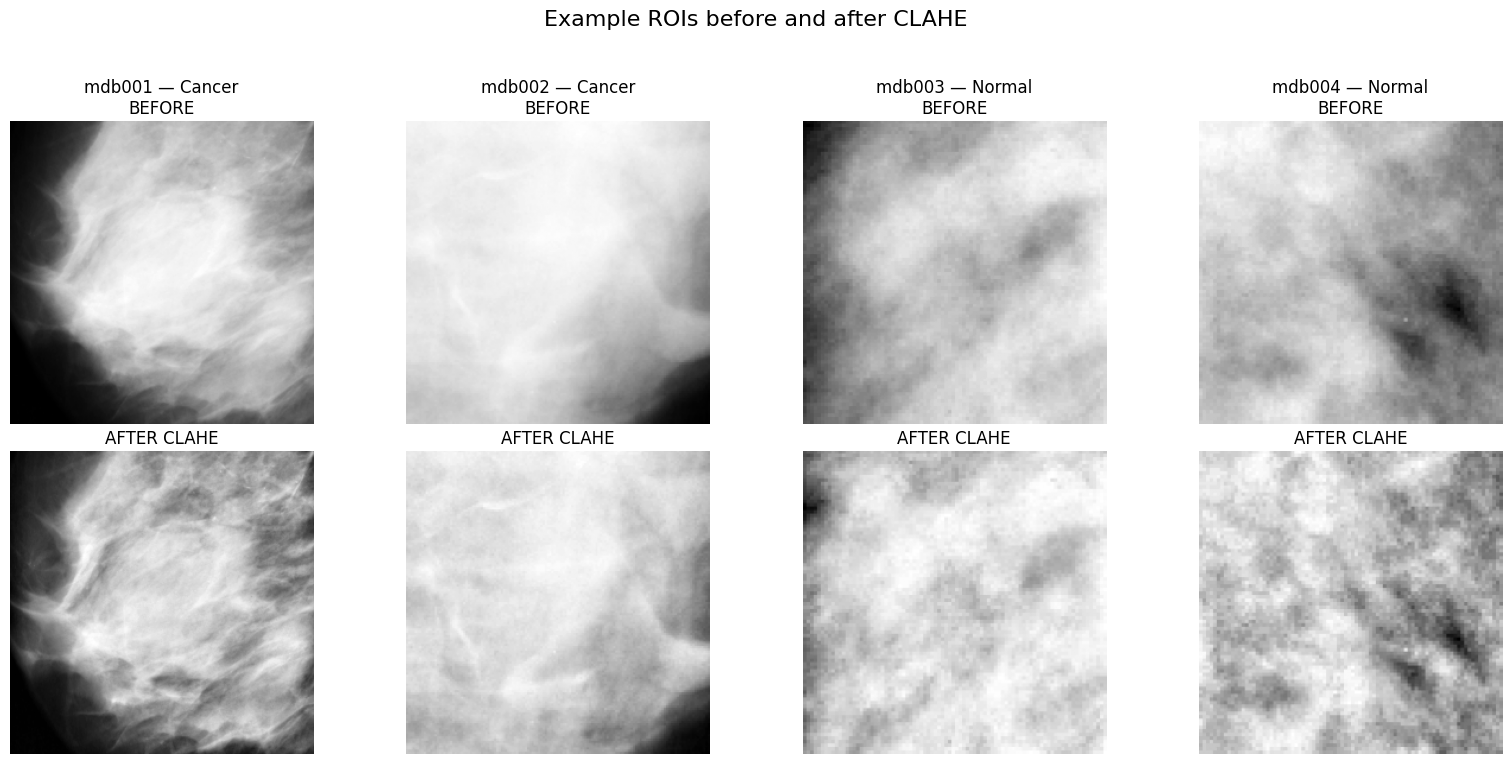

Saved figure to sample_rois_before_after.png


In [14]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG ---
images_path = "all-mias"          # path to your PGM files
meta_path = "data2.txt"           # your metadata
out_figure = "sample_rois_before_after.png"
roi_size = 256                    # final display size (resize)
num_pairs = 4                     # total pairs to show

# --- READ METADATA (same columns you used) ---
col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
df = pd.read_csv(meta_path, sep=r"\s+", names=col_names, header=None)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)

# --- helper functions ---
def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img

def apply_clahe(img, clip=2.0, grid=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=grid)
    return clahe.apply(img)

def crop_roi(img, cx, cy, r):
    H, W = img.shape
    x0 = max(0, int(cx - r))
    x1 = min(W, int(cx + r))
    y0 = max(0, int(cy - r))
    y1 = min(H, int(cy + r))
    roi = img[y0:y1, x0:x1]
    # pad if too small
    if roi.size == 0:
        return img.copy()
    h,w = roi.shape
    if h == 0 or w == 0:
        return img.copy()
    return roi

def center_crop_with_radius(img, r):
    H, W = img.shape
    cx, cy = W // 2, H // 2
    return crop_roi(img, cx, cy, int(r))

# --- gather candidates (keep ref, label, x,y,r) ---
candidates = []
for fname in sorted(os.listdir(images_path)):
    if not fname.lower().endswith('.pgm'):
        continue
    ref = os.path.splitext(fname)[0]
    row = df[df['REFNUM'] == ref]
    if row.empty:
        continue
    row = row.iloc[0]
    labels = int(row['CANCER'])
    x, y, r = row['X'], row['Y'], row['RADIUS']
    candidates.append({
        'ref': ref,
        'file': os.path.join(images_path, fname),
        'label': labels,
        'x': x, 'y': y, 'r': r
    })

# --- choose examples: try to pick half abnormal half normal if possible ---
abn = [c for c in candidates if c['label']==1]
norm = [c for c in candidates if c['label']==0]

selected = []
# prefer 2 abn + 2 norm if available
need_abn = num_pairs // 2
need_norm = num_pairs - need_abn
selected.extend(abn[:need_abn])
selected.extend(norm[:need_norm])

# fallback: if not enough in one class, fill from the other
if len(selected) < num_pairs:
    remaining = [c for c in candidates if c not in selected]
    selected.extend(remaining[:(num_pairs - len(selected))])

# --- build before/after crops ---
pairs = []  # list of tuples (ref, label, crop_before, crop_after)
median_radius = int(pd.to_numeric(df['RADIUS'], errors='coerce').dropna().median())

for c in selected:
    img = read_img(c['file'])
    if img is None:
        continue
    # handle MIAS Y origin: convert bottom-left Y to top-left indexing
    x = c['x']; y = c['y']; r = c['r']
    if pd.notna(x) and pd.notna(y) and pd.notna(r) and c['label']==1:
        cx = int(x)
        cy = int(1024 - float(y))   # MIAS bottom-left -> top-left
        rr = int(r)
        crop_before = crop_roi(img, cx, cy, rr)
    else:
        # normal or missing coordinates: center crop with median radius
        crop_before = center_crop_with_radius(img, median_radius)

    crop_after = apply_clahe(crop_before)
    # resize both for consistent display
    crop_before = cv2.resize(crop_before, (roi_size, roi_size), interpolation=cv2.INTER_AREA)
    crop_after = cv2.resize(crop_after, (roi_size, roi_size), interpolation=cv2.INTER_AREA)
    pairs.append((c['ref'], c['label'], crop_before, crop_after))

# --- PLOT: 2 rows x num_pairs columns (top: before, bottom: after) ---
n = len(pairs)
fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
for i, (ref, label, before, after) in enumerate(pairs):
    axb = axes[0, i] if n>1 else axes[0]
    axa = axes[1, i] if n>1 else axes[1]
    axb.imshow(before, cmap='gray')
    axb.set_title(f"{ref} — {'Cancer' if label==1 else 'Normal'}\nBEFORE")
    axb.axis('off')
    axa.imshow(after, cmap='gray')
    axa.set_title("AFTER CLAHE")
    axa.axis('off')

plt.suptitle("Example ROIs before and after CLAHE", fontsize=16)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.savefig(out_figure, dpi=300)
plt.show()

print("Saved figure to", out_figure)


c:\python3\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Computed LBP for 324 samples. Pooled descriptor dim per sample: 2124
Plotting representative Normal sample (index 2)


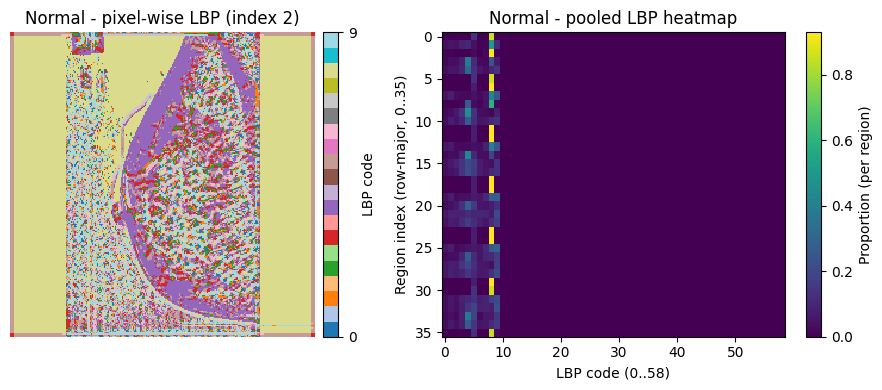

Plotting representative Abnormal sample (index 0)


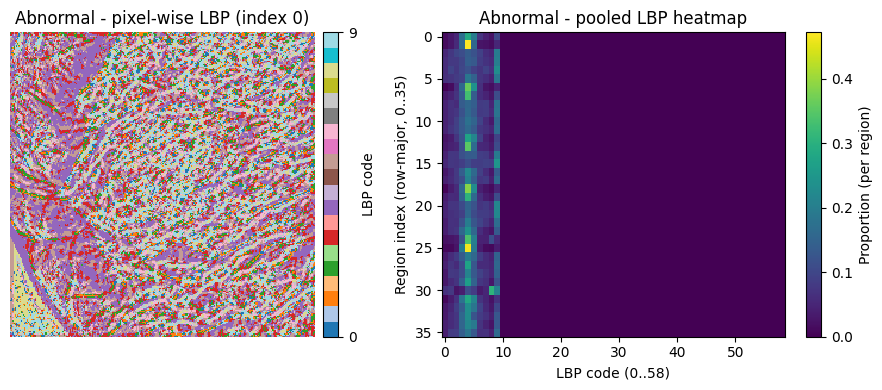

GLCM feature matrix shape: (324, 13)
   contrast_mean   contrast_var  dissimilarity_mean  dissimilarity_var  \
0     117.391427    7297.511236            7.270573           9.409434   
1      19.812110     186.927860            3.125081           1.573940   
2     365.555063   78600.626153            6.565108           9.672931   
3     460.872543  129591.976105            7.249875          12.577701   
4      39.197109     858.594241            4.168859           3.119797   

   homogeneity_mean  homogeneity_var  ASM_mean       ASM_var  energy_mean  \
0          0.184442         0.005042  0.000339  1.429746e-08     0.018130   
1          0.322144         0.014375  0.001044  2.321923e-07     0.031542   
2          0.569111         0.001664  0.176609  1.137524e-04     0.420054   
3          0.540402         0.001760  0.156318  8.633963e-05     0.395193   
4          0.279597         0.014106  0.000733  1.493392e-07     0.026271   

   energy_var  correlation_mean  correlation_var  label

C:\Users\aa23147\AppData\Local\Temp\ipykernel_12628\2291147668.py:148: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Normal', 'Abnormal'])
C:\Users\aa23147\AppData\Local\Temp\ipykernel_12628\2291147668.py:148: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Normal', 'Abnormal'])
C:\Users\aa23147\AppData\Local\Temp\ipykernel_12628\2291147668.py:148: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Normal', 'Abnormal'])
C:\Users\aa23147\AppData\Local\Temp\ipykernel_12628\2291147668.py:148: MatplotlibDeprecationWarni

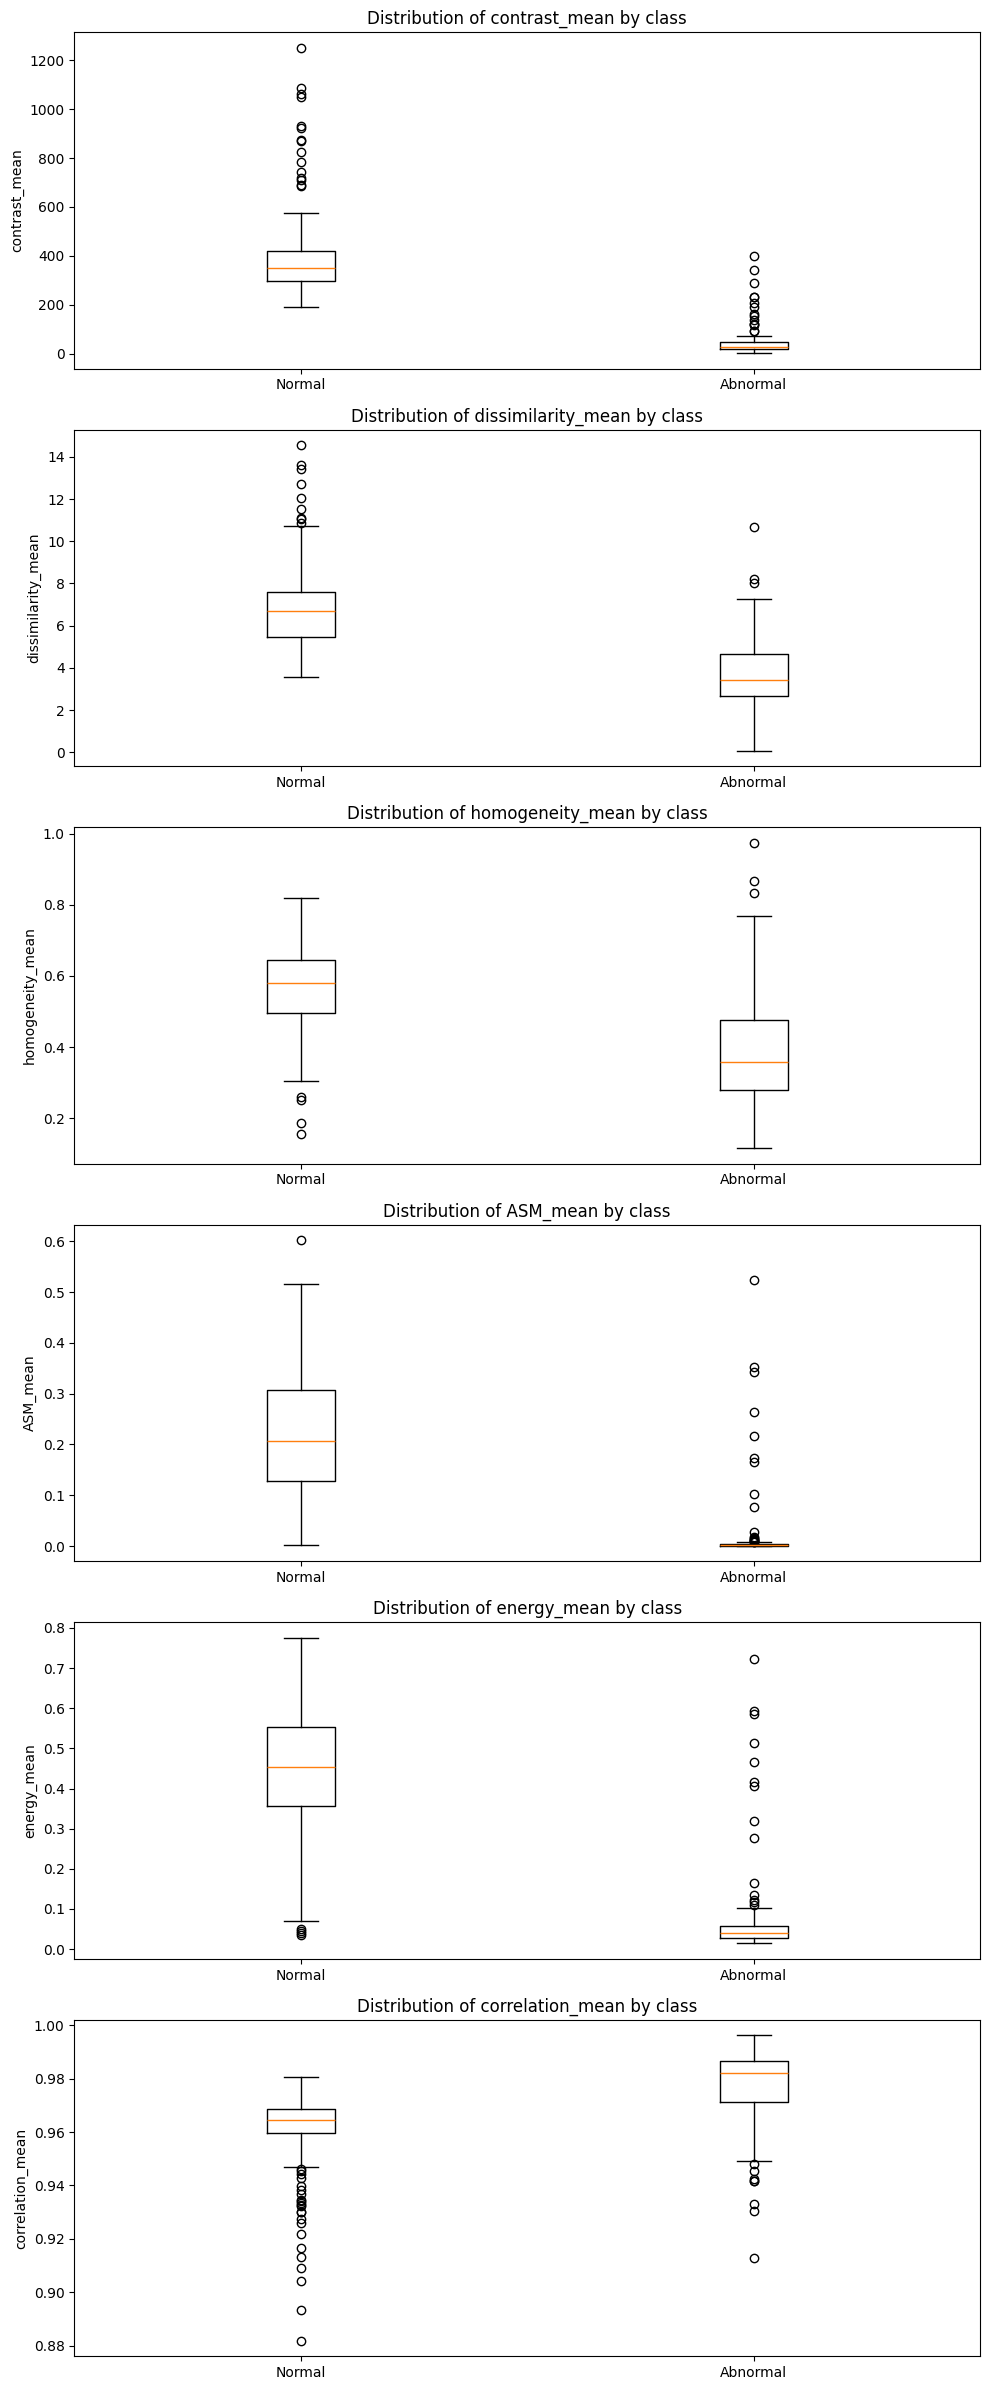


Feature summary (descriptor sizes and sample counts):
                          0
LBP_descriptor_length  2124
GLCM_feature_count       12
n_samples               324
n_normals               207
n_abnormals             117

Selected feature stats by class:
               feature     class        mean         std  count
0        contrast_mean    Normal  390.304063  161.022210    207
1        contrast_mean  Abnormal   49.628459   65.319515    117
2   dissimilarity_mean    Normal    6.775185    1.891928    207
3   dissimilarity_mean  Abnormal    3.665569    1.608633    117
4     homogeneity_mean    Normal    0.568965    0.112195    207
5     homogeneity_mean  Abnormal    0.399850    0.166576    117
6             ASM_mean    Normal    0.218758    0.110964    207
7             ASM_mean  Abnormal    0.021724    0.075045    117
8          energy_mean    Normal    0.448931    0.131132    207
9          energy_mean  Abnormal    0.078598    0.124419    117
10    correlation_mean    Normal    0.9

In [15]:
# Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

# --- Parameters (tweak if needed) ---
P = 8
R = 3
method = 'uniform'
n_bins = 59      # uniform mapping for P=8
G = 6            # pooling grid (6x6)
glcm_distances = [1, 3, 5]
glcm_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
glcm_levels = 256

# --- Helper functions (robust to image dtype) ---
def compute_lbp_map(img, P=8, R=3, method='uniform'):
    """Return integer LBP codes (2D array). Accepts img in any numeric range."""
    # Ensure float input for skimage; local_binary_pattern returns float codes
    imgf = img.astype('float32')
    lbp = local_binary_pattern(imgf, P, R, method=method)
    return lbp.astype(int)

def partition_edges(length, G):
    """Return integer edges for splitting a dimension into G bins (robust)."""
    return np.linspace(0, length, G + 1, dtype=int)

def pooled_lbp_matrix(lbp_map, G=6, n_bins=59):
    """Return M shape (G*G, n_bins) where each row is L1-normalized hist for one region."""
    H, W = lbp_map.shape
    row_edges = partition_edges(H, G)
    col_edges = partition_edges(W, G)
    rows = []
    for i in range(G):
        for j in range(G):
            r0, r1 = row_edges[i], row_edges[i+1]
            c0, c1 = col_edges[j], col_edges[j+1]
            region = lbp_map[r0:r1, c0:c1]
            hist = np.bincount(region.ravel(), minlength=n_bins).astype(float)
            if hist.sum() > 0:
                hist /= hist.sum()   # L1 normalization per region
            rows.append(hist)
    M = np.vstack(rows)   # (G*G, n_bins)
    return M

def extract_glcm_features(patch, distances=[1,3,5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256):
    """Return dict of glcm features: for each prop -> mean and var across distances/angles."""
    # Ensure uint8 input in [0, levels-1]
    p = patch
    if p.max() <= 1.0:
        p = (p * (levels - 1)).astype(np.uint8)
    else:
        p = p.astype(np.uint8)
    glcm = graycomatrix(p,
                        distances=distances,
                        angles=angles,
                        levels=levels,
                        symmetric=True,
                        normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    feats = {}
    for prop in props:
        mat = graycoprops(glcm, prop)   # shape (len(distances), len(angles))
        feats[f'{prop}_mean'] = float(np.nanmean(mat))
        feats[f'{prop}_var']  = float(np.nanvar(mat))
    return feats

# --- 1) Compute LBP maps and pooled matrices for all samples ---
lbp_maps = []
pooled_Ms = []       # each M is (G*G, n_bins)
lbp_flat_vectors = [] # flattened pooled descriptor (G*G*n_bins)
for img in all_images:
    # ensure image in numeric form; if float in [0,1] or 0..255 it's ok
    arr = img.copy()
    if arr.dtype != np.uint8 and arr.max() > 0:
        # scale to 0..255 if it looks like 0..1 floats
        if arr.max() <= 1.0:
            arr = (arr * 255).astype(np.uint8)
        else:
            arr = arr.astype(np.uint8)
    lbp = compute_lbp_map(arr, P=P, R=R, method=method)
    M = pooled_lbp_matrix(lbp, G=G, n_bins=n_bins)
    lbp_maps.append(lbp)
    pooled_Ms.append(M)
    lbp_flat_vectors.append(M.ravel())   # flattened (G*G*n_bins,)

print("Computed LBP for", len(lbp_maps), "samples. Pooled descriptor dim per sample:", pooled_Ms[0].size)

# --- 2) Pick one Normal and one Abnormal for visualization ---
# Find indices
labels_arr = np.array(all_labels)
try:
    idx_abn = int(np.where(labels_arr == 1)[0][0])
except IndexError:
    idx_abn = 0
try:
    idx_norm = int(np.where(labels_arr == 0)[0][0])
except IndexError:
    idx_norm = 0

def plot_lbp_and_heatmap(idx, title_prefix="Sample"):
    lbp = lbp_maps[idx]
    M = pooled_Ms[idx]
    # pixel-wise LBP map (discrete colors)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(lbp, cmap='tab20', interpolation='nearest')
    plt.title(f"{title_prefix} - pixel-wise LBP (index {idx})")
    plt.axis('off')
    cbar = plt.colorbar(ticks=np.linspace(0, n_bins-1, 7).astype(int), fraction=0.046, pad=0.02)
    cbar.set_label('LBP code')
    # pooled heatmap
    plt.subplot(1,2,2)
    plt.imshow(M, aspect='auto', cmap='viridis')
    plt.xlabel('LBP code (0..{})'.format(n_bins-1))
    plt.ylabel('Region index (row-major, 0..{})'.format(G*G-1))
    plt.title(f"{title_prefix} - pooled LBP heatmap")
    plt.colorbar(label='Proportion (per region)')
    plt.tight_layout()
    plt.show()

# Plot Normal and Abnormal
print("Plotting representative Normal sample (index {})".format(idx_norm))
plot_lbp_and_heatmap(idx_norm, title_prefix="Normal")
print("Plotting representative Abnormal sample (index {})".format(idx_abn))
plot_lbp_and_heatmap(idx_abn, title_prefix="Abnormal")

# --- 3) Compute GLCM features for all samples and build a DataFrame ---
glcm_records = []
for img, lab in zip(all_images, all_labels):
    feats = extract_glcm_features(img, distances=glcm_distances, angles=glcm_angles, levels=glcm_levels)
    feats['label'] = int(lab)
    glcm_records.append(feats)

glcm_df = pd.DataFrame.from_records(glcm_records)
print("GLCM feature matrix shape:", glcm_df.shape)
print(glcm_df.head())

# --- 4) Boxplots for selected GLCM features (contrast_mean, homogeneity_mean, ASM_mean) ---
selected = ['contrast_mean', 'dissimilarity_mean', 'homogeneity_mean', 'ASM_mean', 'energy_mean', 'correlation_mean']
plt.figure(figsize=(10, 4*len(selected)))
for i, feat in enumerate(selected):
    plt.subplot(len(selected), 1, i+1)
    # boxplot grouped by label (0/1)
    data0 = glcm_df[glcm_df['label']==0][feat].dropna()
    data1 = glcm_df[glcm_df['label']==1][feat].dropna()
    plt.boxplot([data0, data1], labels=['Normal', 'Abnormal'])
    plt.title(f"Distribution of {feat} by class")
    plt.ylabel(feat)
plt.tight_layout()
plt.show()

# Optional: show violin or swarm plots if you prefer seaborn:
# import seaborn as sns
# sns.boxplot(x='label', y='contrast_mean', data=glcm_df)

# --- 5) Feature summary table ---
# LBP descriptor length
lbp_descriptor_length = G * G * n_bins
glcm_feature_count = len([c for c in glcm_df.columns if c != 'label'])
summary = {
    'LBP_descriptor_length': lbp_descriptor_length,
    'GLCM_feature_count': glcm_feature_count,
    'n_samples': len(all_images),
    'n_normals': int((labels_arr==0).sum()),
    'n_abnormals': int((labels_arr==1).sum())
}
# summary stats for selected features (mean, std) grouped by class
stats = []
for feat in selected:
    for cls in [0,1]:
        grp = glcm_df[glcm_df['label']==cls][feat].dropna()
        stats.append({
            'feature': feat,
            'class': 'Normal' if cls==0 else 'Abnormal',
            'mean': float(grp.mean()),
            'std': float(grp.std()),
            'count': int(len(grp))
        })
stats_df = pd.DataFrame(stats)

# Combine into a final summary object / dataframe for export
feature_summary_df = pd.DataFrame([summary])
print("\nFeature summary (descriptor sizes and sample counts):")
print(feature_summary_df.T)

print("\nSelected feature stats by class:")
print(stats_df)

# Save CSVs for later insertion into thesis/tables
feature_summary_df.to_csv("feature_summary_descriptor_sizes.csv", index=False)
stats_df.to_csv("feature_stats_by_class.csv", index=False)
print("Saved feature summary CSVs.")

# --- 6) Quick checks: skewness / outliers for selected features ---
skews = {feat: float(glcm_df[feat].skew()) for feat in selected}
print("\nSkewness of selected GLCM features:", skews)

# If any feature is highly skewed (abs(skew) > 1), note to apply a transform or robust scaling
for feat, sk in skews.items():
    if abs(sk) > 1:
        print(f"Note: {feat} is highly skewed (skew={sk:.2f}). Consider log-transform or robust scaling before some classifiers.")


Number of ROIs: 324
Number of refs: 324
GLCM rows: (324, 13)

Unique ROI shapes and counts: Counter({(256, 256): 324})

ROI shapes per class (label -> counts):
Label 1 : {(256, 256): 117}
Label 0 : {(256, 256): 207}

No ROIS_RAW provided. If you want to compare raw vs CLAHE, re-run ROI extraction saving pre-CLAHE crops in 'rois_raw' list.

Top 8 indices by contrast_mean:
 [279, 148, 50, 146, 66, 145, 111, 130]


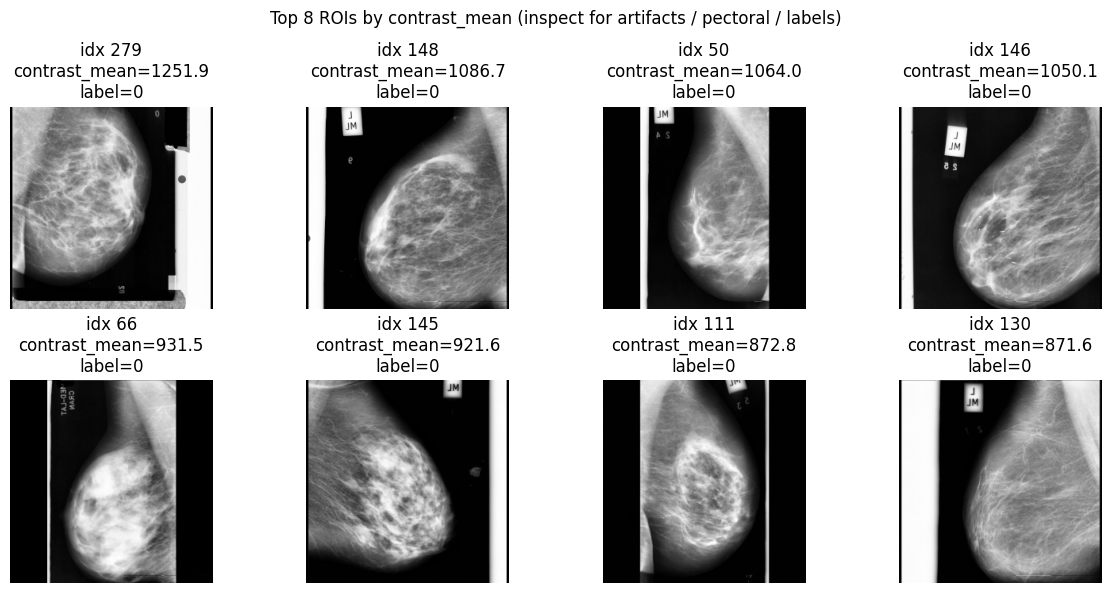

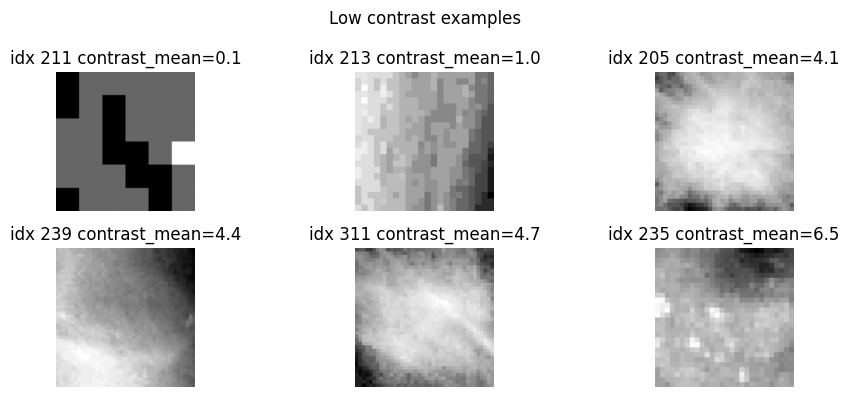


Compare original vs quantized GLCM (sample top outlier indices):
idx 279: contrast_mean orig=1251.9 q32=19.1 | ASM_mean orig=0.007684 q32=0.036125
idx 148: contrast_mean orig=1086.7 q32=16.6 | ASM_mean orig=0.071392 q32=0.084319
idx 50: contrast_mean orig=1064.0 q32=16.2 | ASM_mean orig=0.131735 q32=0.166957
idx 146: contrast_mean orig=1050.1 q32=15.8 | ASM_mean orig=0.002136 q32=0.050952

Contrast skewness before transform: 1.0541494811147816
Contrast skewness after log1p: -0.9477078882402591

Mann-Whitney U test and Cliff's delta for selected features:
contrast_mean: U=23921.00 p=3.584e-48  Cliff's delta=0.975  (n0=207, n1=117)
homogeneity_mean: U=19711.00 p=6.282e-21  Cliff's delta=0.628  (n0=207, n1=117)
ASM_mean: U=22988.00 p=3.961e-41  Cliff's delta=0.898  (n0=207, n1=117)

Summary stats for selected features by class:
            feature  class        mean      median         std         iqr  \
0     contrast_mean      0  390.304063  350.847924  160.632796  123.420165   
1     

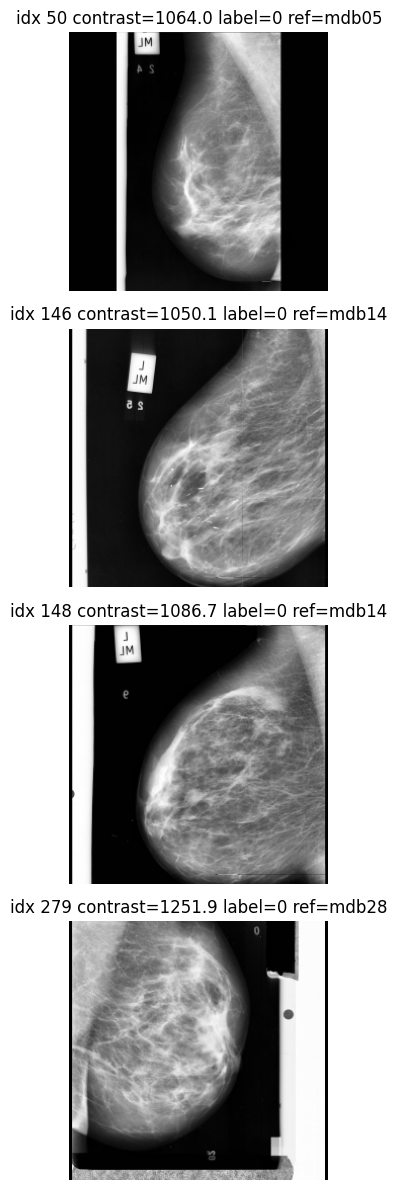


Done. Review the displayed ROIs and the statistical outputs above.


In [16]:
# Sanity checks & small analyses for GLCM / ROIs
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import mannwhitneyu
import cv2, math, os

# === CONFIG: adapt names if needed ===
ROIS = globals().get('rois', globals().get('all_images', None))   # CLAHE-applied ROIs
ROIS_RAW = globals().get('rois_raw', None)                       # optional: raw crops pre-CLAHE
REFS = globals().get('refs', globals().get('all_groups', None))  # reference ids aligned with ROIS
GLCM_DF = globals().get('glcm_df', globals().get('glcm', None))   # dataframe with glcm features + 'label'
IMAGE_FOLDER = "all-mias"  # used only if reconstructing raw crops (optional)
META_DF = globals().get('df', None)  # metadata if needed to reconstruct crops

# Basic checks
assert ROIS is not None, "ROIS is not defined - run ROI extraction cell first and set 'rois' or 'all_images'."
assert GLCM_DF is not None and 'label' in GLCM_DF.columns, "glcm_df with 'label' column is required."

print("Number of ROIs:", len(ROIS))
if REFS is not None:
    print("Number of refs:", len(REFS))
print("GLCM rows:", GLCM_DF.shape)

# 1) Confirm ROI shapes (are normals/abnormals same size?)
shapes = [tuple(r.shape) for r in ROIS]
shape_counts = Counter(shapes)
print("\nUnique ROI shapes and counts:", shape_counts)

# grouping by label (from glcm_df assumed matching order)
labels = list(GLCM_DF['label'].astype(int).values)
shape_by_label = {}
for s, lab in zip(shapes, labels):
    shape_by_label.setdefault(lab, Counter())[s] += 1
print("\nROI shapes per class (label -> counts):")
for lab, ctr in shape_by_label.items():
    print("Label", lab, ":", dict(ctr))

# 2) Verify CLAHE applied per-ROI if raw available (compare statistics)
if ROIS_RAW is not None:
    print("\nComparing raw vs CLAHE ROI stats (first 5 samples):")
    for i in range(min(5, len(ROIS))):
        raw = ROIS_RAW[i].astype(np.float32)
        clahe = ROIS[i].astype(np.float32)
        print(f"idx {i}: raw mean={raw.mean():.2f} std={raw.std():.2f} | clahe mean={clahe.mean():.2f} std={clahe.std():.2f} | mean_abs_diff={(np.abs(raw-clahe)).mean():.2f}")
    print("If ROIS_RAW not present, consider re-running ROI extraction storing pre-CLAHE crops in 'rois_raw'.")
else:
    print("\nNo ROIS_RAW provided. If you want to compare raw vs CLAHE, re-run ROI extraction saving pre-CLAHE crops in 'rois_raw' list.")

# 3) Identify extreme contrast outliers (top N) and display them
feature_col = 'contrast_mean'
if feature_col not in GLCM_DF.columns:
    raise ValueError(f"{feature_col} not found in glcm_df columns: {GLCM_DF.columns.tolist()}")

N = 8
top_idx = GLCM_DF[feature_col].nlargest(N).index.tolist()
print(f"\nTop {N} indices by {feature_col}:\n", top_idx)
plt.figure(figsize=(12, 3*math.ceil(N/4)))
for k, idx in enumerate(top_idx):
    roi_idx = idx  # assumes rows align with ROIS order
    roi_img = ROIS[roi_idx]
    plt.subplot(math.ceil(N/4), 4, k+1)
    plt.imshow(roi_img, cmap='gray'); plt.title(f"idx {roi_idx}\n{feature_col}={GLCM_DF.loc[idx,feature_col]:.1f}\nlabel={int(GLCM_DF.loc[idx,'label'])}")
    plt.axis('off')
plt.suptitle(f"Top {N} ROIs by {feature_col} (inspect for artifacts / pectoral / labels)")
plt.tight_layout()
plt.show()

# Also show a few low-contrast ROIs for comparison
low_idx = GLCM_DF[feature_col].nsmallest(6).index.tolist()
plt.figure(figsize=(10,4))
for k, idx in enumerate(low_idx):
    plt.subplot(2, 3, k+1); plt.imshow(ROIS[idx], cmap='gray')
    plt.title(f"idx {idx} {feature_col}={GLCM_DF.loc[idx,feature_col]:.1f}"); plt.axis('off')
plt.suptitle("Low contrast examples")
plt.tight_layout()
plt.show()

# 4) Quantize ROI to fewer gray levels and recompute GLCM for a sample (function)
from skimage.feature import graycomatrix, graycoprops

def quantize_img(img, levels=32):
    # accepts uint8 or float; returns uint8 in 0..levels-1
    a = img.astype(np.float32)
    if a.max() > 1.1:  # likely 0..255
        a = a / 255.0
    q = np.floor(a * (levels - 1) + 0.5).astype(np.uint8)
    return q

def compute_glcm_stats(img, distances=[1,3,5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=32):
    q = quantize_img(img, levels=levels)
    glcm = graycomatrix(q, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    out = {}
    for p in props:
        mat = graycoprops(glcm, p)
        out[f"{p}_mean"] = float(np.nanmean(mat))
        out[f"{p}_var"]  = float(np.nanvar(mat))
    return out

# Compare original (levels=256) vs quantized (levels=32) for top outliers
print("\nCompare original vs quantized GLCM (sample top outlier indices):")
for idx in top_idx[:4]:
    orig_stats = compute_glcm_stats(ROIS[idx], levels=256)
    q_stats = compute_glcm_stats(ROIS[idx], levels=32)
    print(f"idx {idx}: contrast_mean orig={orig_stats['contrast_mean']:.1f} q32={q_stats['contrast_mean']:.1f} | ASM_mean orig={orig_stats['ASM_mean']:.6f} q32={q_stats['ASM_mean']:.6f}")

# 5) Transformations: compare skewness and optional log1p transform for contrast_mean
from scipy.stats import skew
cm = GLCM_DF[feature_col].dropna()
print("\nContrast skewness before transform:", float(skew(cm)))
cm_log = np.log1p(cm)
print("Contrast skewness after log1p:", float(skew(cm_log)))

# 6) Mann-Whitney U test + Cliff's delta effect size for selected features
def cliffs_delta(xs, ys):
    # simple O(n*m) implementation
    xs = np.asarray(xs); ys = np.asarray(ys)
    n = len(xs); m = len(ys)
    greater = 0
    less = 0
    for x in xs:
        greater += np.sum(x > ys)
        less += np.sum(x < ys)
    delta = (greater - less) / (n * m)
    return delta

selected_feats = ['contrast_mean', 'homogeneity_mean', 'ASM_mean']
print("\nMann-Whitney U test and Cliff's delta for selected features:")
for feat in selected_feats:
    a = GLCM_DF[GLCM_DF['label']==0][feat].dropna().values
    b = GLCM_DF[GLCM_DF['label']==1][feat].dropna().values
    if len(a)==0 or len(b)==0:
        print(f"{feat}: not enough samples for test")
        continue
    stat, p = mannwhitneyu(a, b, alternative='two-sided')
    delta = cliffs_delta(a, b)
    print(f"{feat}: U={stat:.2f} p={p:.3e}  Cliff's delta={delta:.3f}  (n0={len(a)}, n1={len(b)})")

# 7) Summary stats (mean, median, IQR) for selected features by class
def iqr(x): return np.percentile(x,75) - np.percentile(x,25)
rows = []
for feat in selected_feats:
    for lab in [0,1]:
        arr = GLCM_DF[GLCM_DF['label']==lab][feat].dropna().values
        rows.append({
            'feature': feat, 'class': lab, 'mean': float(np.mean(arr)), 'median': float(np.median(arr)),
            'std': float(np.std(arr)), 'iqr': float(iqr(arr)), 'n': int(len(arr))
        })
summary_df = pd.DataFrame(rows)
print("\nSummary stats for selected features by class:")
print(summary_df)

# 8) Optional: list indices where contrast_mean extremely high (possible artifacts)
thresh = np.percentile(GLCM_DF['contrast_mean'], 99)  # top 1%
high_idx = GLCM_DF[GLCM_DF['contrast_mean'] > thresh].index.tolist()
print(f"\nIndices above 99th percentile ({thresh:.1f}):", high_idx)
if len(high_idx):
    plt.figure(figsize=(10,3*len(high_idx)))
    for i, idx in enumerate(high_idx):
        plt.subplot(len(high_idx), 1, i+1)
        plt.imshow(ROIS[idx], cmap='gray')
        title = f"idx {idx} contrast={GLCM_DF.loc[idx,'contrast_mean']:.1f} label={int(GLCM_DF.loc[idx,'label'])}"
        if REFS is not None and idx < len(REFS):
            title += f" ref={REFS[idx]}"
        plt.title(title); plt.axis('off')
    plt.tight_layout(); plt.show()

print("\nDone. Review the displayed ROIs and the statistical outputs above.")
